### Autoregressive Models

Let $\mathbf{X}$ be a matrix of lagged time series values and $\mathbf{y}$ be a vector of p+1 values:
$$
    \mathbf{X}_{m\times p} =
        \left[ {\begin{array}{ccccc}
        x_{0} & x_{1} & x_{2} & \cdots & x_{p}\\
        x_{1} & x_{2} & x_{3} & \cdots & x_{p+1}\\
        x_{2} & x_{3} & x_{4} & \cdots & x_{p+2}\\
        \vdots & \vdots & \vdots & \ddots & \vdots\\
        x_{n-p-1} & x_{n-p} & x_{n-p+1} & \cdots & x_{n-1}\\
        \end{array} } \right] \\
    \mathbf{y} = 
        \left[ {\begin{array}{c}
        x_{p+1} \\
        x_{p+2} \\
        x_{p+3} \\ 
        \cdots \\
        x_{n} \\ 
        \end{array} } \right] \\\\
$$

Autoregression (AR) solves for a vector of weights, $\mathbf{b}$, that best predicts $\mathbf{y}$.

$$
\mathbf{X} \mathbf{b} = \mathbf{y}
$$

#### SVD
Singular value decomposition (SVD) may be used to solve the pseudo inverse of $\mathbf{X}$:

$$
\begin{align}
\mathbf{b} &= \mathbf{X}^{-1}\mathbf{y} \\
\mathbf{b} &= \mathbf{V}\mathbf{\Sigma}^{-1}\mathbf{U}^{\top}\mathbf{y}
\end{align}
$$


Although SVD can solve most problems, the decomposition is solved in $O(n^2p+p^3)$ time. Large orders, $p$, drastically increses the compute time relative to other methods. Faster, but less accurate, solutions, in the case of stochastic signals, are provided by Yule-Walker or Burg's methods.

#### Yule-Walker Method
The Yule-Waker solution is unstable as the condition number of the covariance matrix ($\mathbf{X}^{\top}\mathbf{X}$) increases or is near singular (e.g. not invertible). This is the case for oscillations when estimated with a large number of lags. Oscillations alone result in identical columns of $\mathbf{X}$ and biased AR coefficients. Oscillations can also causes issues for SVD.

#### Burg's Method
Burg's solution is an iterative method that defines a forward, $\mathbf{f}$, and backward ,$\mathbf{b}$, shifted signal, $\mathbf{y}$. The algorithm iterates from zero to the AR order, $p$, indexed below as $j$. The forward vector shifts the signal ahead $j$ samples and the backward vector removes samples beyond $n+j$, where $n$ is the total number of samples in the signal. During each iteration, from zero to $p$, indexed with $j$, the forward and backward vectors are defined as:

$$
\begin{align}
\mathbf{f} &= \mathbf{y}_{i}, i \in i > j\\
\mathbf{b} &= \mathbf{y}_{i}, i \in i < n-j
\end{align}
$$

The reflection coefficient is computed as
$$
\mathbf{k}_j = \frac{-2 \mathbf{b}^{\top}\mathbf{f}}{\mathbf{f}^{\top}\mathbf{f} + \mathbf{b}^{\top}\mathbf{b}}
$$
AR coefficients for the current iteration are equal to
$$
\mathbf{a}_j = -\mathbf{k}_j
$$
Past AR coefficients, $\mathbf{a}_k$ are updated as
$$
\mathbf{a}_k  = \mathbf{a}_k - J(\mathbf{a}_j) \quad\forall\quad 0 < k < j
$$
where $J$ is an exchange matrix the reverses the order of past coeffcients $\mathbf{a}_k$.

Lastly, the forward and backward vectors are updated before moving to the next jth iteration:
$$
\begin{align}
\mathbf{f} &+ \mathbf{k}_{j}\mathbf{b} \\
\mathbf{b} &+ \mathbf{k}_{j}\mathbf{f}
\end{align}
$$



#### Current

This notebook compares the performance and runtime of SVD, Yule-Walker, and Burg's methods.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.linalg import svd
from statsmodels.regression.linear_model import yule_walker
from timescales.sim import sim_branching
from timescales.autoreg import burg
from timescales.conversions import ar_to_psd

In [2]:
# Simulate
n_seconds = 2
fs = 1000
tau = 0.01
sig = sim_branching(n_seconds, fs, tau, 1000,
                    mean=0, variance=1)
# AR order
p = 20
y = sig[p:]

# Fast lagging of signal
X = np.lib.stride_tricks.as_strided(sig,
    shape=(len(sig)-p+1, p),
    strides=((sig.itemsize, sig.itemsize))
)[:-1]

#### Performance

SVD and Yule-Walker methods are ~100 and ~2 times slower than Burg's method, respectively. All methods are approximately equivalent in terms of MSE, however MSE SVD < MSE Burg < MSE Yule-Walker) for stochastic timescales simulations.

In [3]:
%%timeit -n 100 -r 1
# SVD
U, S, Vt = svd(X, full_matrices=False,
               overwrite_a=False, check_finite=False)
ar_coeffs = Vt.T @ np.diag(1/S) @ U.T @ y

295 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 100 loops each)


In [4]:
%%timeit -n 500 -r 1
# Yule-Walker
ar_coeffs, _ = yule_walker(y, order=p, demean=False)

480 µs ± 0 ns per loop (mean ± std. dev. of 1 run, 500 loops each)


In [5]:
%%timeit -n 500 -r 1 
ar_coeffs = burg(y, p, demean=False)

290 µs ± 0 ns per loop (mean ± std. dev. of 1 run, 500 loops each)


In [6]:
# SVD
U, S, Vt = svd(X, full_matrices=False,
               overwrite_a=False, check_finite=False)
ar_coeffs_svd = Vt.T @ np.diag(1/S) @ U.T @ y

# YW
ar_coeffs_yw, _ = yule_walker(y, order=p, demean=False)

# Burg
ar_coeffs_burg = burg(y, p, demean=False)

print("MSE SVD : ", (((X@ar_coeffs_svd)-y)**2).mean())
print("MSE YW  : ", (((X@ar_coeffs_yw[::-1])-y)**2).mean())
print("MSE Burg: ", (((X@ar_coeffs_burg[::-1])-y)**2).mean())

MSE SVD :  0.15398259881048634
MSE YW  :  0.15398890493224976
MSE Burg:  0.15398818982471496


#### Oscillations
In the case of oscillations, Burg's method is the least bias estimator.

In [9]:
# Simulate oscillation
n_seconds = 5
fs = 1000
y = np.sin(2 * np.pi * 5 * np.arange(0, n_seconds, 1/fs))
y += np.sin(2 * np.pi * 13 * np.arange(0, n_seconds, 1/fs))

# Normalize
y = y - y.mean()
y = y / y.std()

# Lag signal
p = 5

X = np.lib.stride_tricks.as_strided(y,
    shape=(len(y)-p+1, p),
    strides=((y.itemsize, y.itemsize))
)[:-1]

y = y[p:]

In [10]:
# Poor conditioning -> issues for yule-walker
eigvals = np.linalg.eigvals(X.T @ X)
print("Condition Number: ", eigvals[0]/eigvals[-1])

Condition Number:  -3520695029694488.0


In [11]:
# SVD
U, S, Vt = svd(X, full_matrices=False,
               overwrite_a=False, check_finite=False)
ar_coeffs_svd = Vt.T @ np.diag(1/S) @ U.T @ y

# YW
ar_coeffs_yw, _ = yule_walker(y, order=p, demean=False)

# Burg
ar_coeffs_burg = burg(y, p, demean=False)

print("MSE SVD : ", (((X@ar_coeffs_svd)-y)**2).mean())
print("MSE YW  : ", (((X@ar_coeffs_yw[::-1])-y)**2).mean())
print("MSE Burg: ", (((X@ar_coeffs_burg[::-1])-y)**2).mean())

MSE SVD :  1.8796005744909768e-07
MSE YW  :  6.768135540392931e-05
MSE Burg:  3.7804740944065134e-16


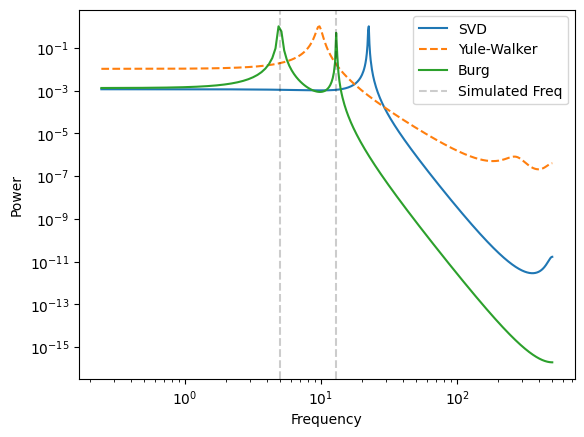

In [12]:
freqs, powers = ar_to_psd(ar_coeffs_svd[::-1], fs, 4096)
powers = powers / powers.max()
plt.loglog(freqs[1:], powers[1:], label='SVD')

freqs, powers = ar_to_psd(ar_coeffs_yw, fs, 4096)
powers = powers / powers.max()
plt.loglog(freqs[1:], powers[1:], ls='--', label='Yule-Walker')

freqs, powers = ar_to_psd(ar_coeffs_burg, fs, 4096)
powers = powers / powers.max()
plt.loglog(freqs[1:], powers[1:], label='Burg')

plt.axvline(5, ls='--', color='k', alpha=.2, label='Simulated Freq')
plt.axvline(13, ls='--', color='k', alpha=.2)

plt.ylabel("Power")
plt.xlabel("Frequency")
plt.legend();